In [ ]:
import pandas as pd
from datetime import timedelta

# Load and sort
df = pd.read_csv('/content/MTA_Daily_Ridership_Data.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.sort_values('Date', inplace=True)

# Aggregate total daily ridership
ridership_cols = [
    'Subways: Total Estimated Ridership',
    'Buses: Total Estimated Ridership',
    'LIRR: Total Estimated Ridership',
    'Metro-North: Total Estimated Ridership',
    'Access-A-Ride: Total Scheduled Trips',
    'Staten Island Railway: Total Estimated Ridership'
]
df['Total_Ridership'] = df[ridership_cols].sum(axis=1)

# Day-of-week feature (0=Mon,…,6=Sun)
df['DayOfWeek'] = df['Date'].dt.weekday  # uses pandas dt accessor :contentReference[oaicite:1]{index=1}

In [ ]:
# 2. Create Supervised X, y for 7-Day Output
look_back = 30
horizon   = 7
series = df['Total_Ridership'].values
dow    = df['DayOfWeek'].values.reshape(-1,1)
data   = np.hstack([series.reshape(-1,1), dow])  # features: [ridership, day-of-week]

X, y = [], []
for i in range(look_back, len(data) - horizon + 1):
    X.append(data[i-look_back:i, :])
    y.append(series[i:i+horizon])
X = np.array(X)  # shape: (n_samples, look_back, 2)
y = np.array(y)  # shape: (n_samples, horizon)

In [ ]:
# 3. Scale Ridership & Handle Broadcast Correctly
scaler      = MinMaxScaler()  # expects 2D input :contentReference[oaicite:4]{index=4}
n_samples   = X.shape[0]
seq_len     = X.shape[1]

In [ ]:
# Fit only on training ridership values to avoid leakage
train_size = int(n_samples * 0.8)
scaler.fit(
    X[:train_size, :, 0]               # ridership column
      .reshape(-1, 1)                  # => shape (train_size*look_back, 1)
)

MinMaxScaler()

In [ ]:
# Flatten, transform, then reshape back to 2D to match (n_samples, look_back)
flat_ridership        = X[:, :, 0].reshape(-1, 1)             # (n_samples*look_back, 1)
flat_ridership_scaled = scaler.transform(flat_ridership)     # (n_samples*look_back, 1)
ridership_scaled      = flat_ridership_scaled.reshape(n_samples, seq_len)

In [ ]:
# Replace only the ridership feature in X_scaled
X_scaled = X.copy()
X_scaled[:, :, 0] = ridership_scaled  # now shape-aligned for broadcasting :contentReference[oaicite:5]{index=5}

# Scale y to [0,1]
y_scaled = scaler.transform(y.reshape(-1, 1)).reshape(y.shape)

# Split into train & validation
X_train, X_val = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_val = y_scaled[:train_size], y_scaled[train_size:]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Define the model
model = Sequential([
    # 1a. Input layer (avoids the input_shape warning)
    Input(shape=(look_back, 2)),

    # 1b. Encoder LSTM
    LSTM(
        units=20,
        activation='tanh',
        dropout=0.2,
        recurrent_dropout=0.2,
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4)
    ),

    # 1c. Bridge to decoder
    RepeatVector(horizon),

    # 1d. Decoder LSTM
    LSTM(
        units=20,
        activation='tanh',
        return_sequences=True,
        dropout=0.2,
        recurrent_dropout=0.2,
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4)
    ),

    # 1e. TimeDistributed output for each of the 7 future steps
    TimeDistributed(
        Dense(1, activation='linear', kernel_regularizer=l2(1e-4))
    )
])

# 2. Compile
model.compile(optimizer='adam', loss='mse')

# 3. Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# 4. Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1386
Epoch 1: val_loss improved from inf to 0.07826, saving model to best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - loss: 0.1378 - val_loss: 0.0783
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0657
Epoch 2: val_loss improved from 0.07826 to 0.06542, saving model to best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0656 - val_loss: 0.0654
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0523
Epoch 3: val_loss improved from 0.06542 to 0.05636, saving model to best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0523 - val_loss: 0.0564
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0495
Epoch 4: val_loss improved from 0.05636 to 0.05368, saving model to best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0495 - val_loss: 0.0537
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0481
Epoch 5: val_loss did not improve from 0.05368
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - loss: 0.0481 - val_loss: 0.0557
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0460
Epoch 6: val_loss improved from 0.05368 to 0.05331, saving model to best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 0.0460 - val_loss: 0.0533
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0440
Epoch 7: val_loss improved from 0.05331 to 0.05282, saving model to best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.0441 - val_loss: 0.0528
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0446
Epoch 8: val_loss improved from 0.05282 to 0.04824, saving model to best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - loss: 0.0446 - val_loss: 0.0482
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0440
Epoch 9: val_loss did not improve from 0.04824
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0440 - val_loss: 0.0524
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0432
Epoch 10: val_loss did not improve from 0.04824
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0432 - val_loss: 0.0521
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0440
Epoch 11: val_loss did not improve from 0.04824
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.0440 - val_loss: 0.0505
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0429
Epoch 12: val_loss did not improve from 0.04824
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0429 - val_loss: 0.0558
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0432
Epoch 13: val_loss did not improve from 0.04824
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.0

In [ ]:
# 7. Forecast Next 7 Days
last_seq = np.hstack([
    series[-look_back:].reshape(-1,1),
    dow[-look_back:]
])
last_scaled = last_seq.copy()
last_scaled[:, 0] = scaler.transform(last_seq[:, 0].reshape(-1,1)).flatten()
pred_scaled = model.predict(last_scaled[np.newaxis, ...])
predicted  = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()

future_dates = [df['Date'].iloc[-1] + timedelta(i) for i in range(1, horizon+1)]
for d, p in zip(future_dates, predicted):
    print(f"{d.date()}: {p:.0f} riders")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
2025-01-10: 3252496 riders
2025-01-11: 3876088 riders
2025-01-12: 3951766 riders
2025-01-13: 3868119 riders
2025-01-14: 3754488 riders
2025-01-15: 3651473 riders
2025-01-16: 3568659 riders


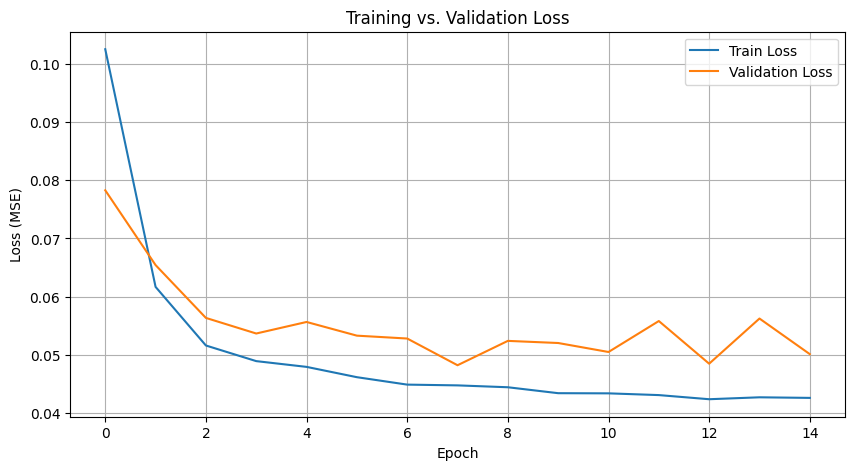

In [ ]:
# 1. Training vs. Validation Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

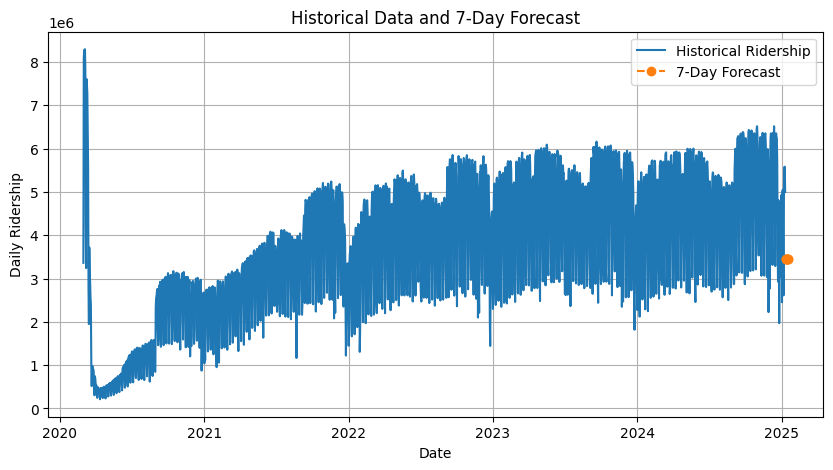

In [ ]:
# 3. Historical Data + 7-Day Forecast
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Total_Ridership'], label='Historical Ridership')
plt.plot(future_dates,   forecast,      '--o', label='7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Daily Ridership')
plt.title('Historical Data and 7-Day Forecast')
plt.legend()
plt.grid(True)
plt.show()